In [2]:
import numpy as np

In [3]:
# construct mapper from qubit to stabilizer
def construct_mapper(L):
    mapper = [[] for _ in range(L*L)]
    for i in range(L*L):
        mapper[i].append(i) #top
        mapper[i].append((i+L) % (L * L)) #bottom
    for i in range(L*L):
        mapper[i].append(i + L*L) #left
        if i % L == L - 1:
            mapper[i].append(i + 1 - L + L*L) #right
        else:
            mapper[i].append(i + 1 + L*L)
    return mapper

#mapper = construct_mapper(L)
#print(mapper)

In [4]:
# generate random errors
import time
import random
def generate_errors(L, p):
    max_errors = 999999999 #int(L/2)
    np.random.seed(random.randint(0, 1000000))
    error_list = []
    for i in range(2*L*L):
        if np.random.rand() < p:
            error_list.append(i)
    if len(error_list) > max_errors:
        error_list = np.random.choice(error_list, max_errors, replace=False)
    return error_list

In [5]:
# syndrome measurement (error detection)
def caluclate_syndrome(L, error_list):
    mapper = construct_mapper(L)
    syndrome = np.zeros(L*L)
    for stabilizer in range(L*L):
        for qubit in mapper[stabilizer]:
            if qubit in error_list:
                syndrome[stabilizer] += 1
    errant_stabilizers = np.where(syndrome % 2 == 1)[0]
    return errant_stabilizers

In [6]:
# visualize the surface code, mark the errors and the syndrome
def visualize_surface_code_error(L, errors):
    print('errant qubits:\n')
    for i in range(L):
        for j in range(L):
            qubit = i*L + j
            if qubit in errors:
                print('   X', end='')
            else:
                print('   |', end='')
        print(' ')
        for j in range(L):
            qubit = i*L + j + L*L
            if qubit in errors:
                print('-X-+', end='')
            else:
                print('---+', end='')
        print('-')
    print('\n')

def visualize_surface_code_syndrome(L, syndrome):
    print('errant stabilizers:\n')
    for i in range(L):
        for j in range(L):
            print('   |', end='')
        print(' ')
        for j in range(L):
            stabilizer = i*L + j
            if stabilizer in syndrome:
                print('---Z', end='')
            else:
                print('---+', end='')
        print('-')
    print('\n')

In [7]:
# error correction with maximum likelihood decoding
# first generate a graph with the error syndrome
class max_likelihood_decoder:
    def __init__(self, L):
        self.L = L
        self.min_path = []
        self.min_distance_record = float('inf')

    def location_of_stabilizer(self, stabilizer):
        return stabilizer // self.L, stabilizer % self.L

    def construct_graph(self, syndrome):
        graph = np.zeros((len(syndrome), len(syndrome)))
        for i in range(len(syndrome)):
            for j in range(len(syndrome)):
                if i != j:
                    x1, y1 = self.location_of_stabilizer(syndrome[i])
                    x2, y2 = self.location_of_stabilizer(syndrome[j])
                    x3, y3 = x2+self.L, y2
                    x4, y4 = x2, y2+self.L
                    x5, y5 = x2-self.L, y2
                    x6, y6 = x2, y2-self.L
                    x7, y7 = x2-self.L, y2-self.L
                    x8, y8 = x2+self.L, y2-self.L
                    graph[i][j] = abs(x1 - x2) + abs(y1 - y2)
                    graph[i][j] = min(graph[i][j], abs(x1 - x3) + abs(y1 - y3))
                    graph[i][j] = min(graph[i][j], abs(x1 - x4) + abs(y1 - y4))
                    graph[i][j] = min(graph[i][j], abs(x1 - x5) + abs(y1 - y5))
                    graph[i][j] = min(graph[i][j], abs(x1 - x6) + abs(y1 - y6))
                    graph[i][j] = min(graph[i][j], abs(x1 - x7) + abs(y1 - y7))
                    graph[i][j] = min(graph[i][j], abs(x1 - x8) + abs(y1 - y8))
        return graph

    def dfs(self, graph, path, visited):
        if len(path) == len(graph):
            distance = 0
            for i in range(len(path) - 1):
                distance += graph[path[i]][path[i+1]]
            distance += graph[path[-1]][path[0]]
            if distance < self.min_distance_record:
                self.min_distance_record = distance
                self.min_path = path.copy()
            return
        for i in range(len(graph)):
            if i not in visited:
                path.append(i)
                visited.add(i)
                self.dfs(graph, path, visited)
                path.pop()

    def which_side_is_the_nearst(self, stabilizer1, stabilizer2):
        x1, y1 = self.location_of_stabilizer(stabilizer1)
        x2, y2 = self.location_of_stabilizer(stabilizer2)
        # print('x1, y1:', x1, y1)
        # print('x2, y2:', x2, y2)
        x3, y3 = x2+self.L, y2
        x4, y4 = x2, y2+self.L
        x5, y5 = x2-self.L, y2
        x6, y6 = x2, y2-self.L
        x7, y7 = x2-self.L, y2-self.L
        x8, y8 = x2-self.L, y2+self.L
        middle_distance = abs(x1 - x2) + abs(y1 - y2)
        bottom_distance = abs(x1 - x3) + abs(y1 - y3)
        right_distance = abs(x1 - x4) + abs(y1 - y4)
        top_distance = abs(x1 - x5) + abs(y1 - y5)
        left_distance = abs(x1 - x6) + abs(y1 - y6)
        top_left_distance = abs(x1 - x7) + abs(y1 - y7)
        top_right_distance = abs(x1 - x8) + abs(y1 - y8)
        min_distance = min(middle_distance, right_distance, bottom_distance, left_distance, top_distance, top_left_distance, top_right_distance)
        if middle_distance == min_distance:
            return 'middle'
        if right_distance == min_distance:
            return 'right'
        if bottom_distance == min_distance:
            return 'bottom'
        if left_distance == min_distance:
            return 'left'
        if top_distance == min_distance:
            return 'top'
        if top_left_distance == min_distance:
            return 'top_left'
        if top_right_distance == min_distance:
            return 'top_right'
        
    def construct_middle_path(self, stabilizer1, stabilizer2):
        x1, y1 = self.location_of_stabilizer(stabilizer1)
        x2, y2 = self.location_of_stabilizer(stabilizer2)
        path = []
        for i in range(min(y1, y2)+1, max(y1, y2)+1):
            path.append(x1*self.L + i + self.L*self.L)
        for i in range(min(x1, x2)+1, max(x1, x2)+1):
            path.append(i*self.L + y2)
        return path
    
    def construct_right_path(self, stabilizer1, stabilizer2):
        x1, y1 = self.location_of_stabilizer(stabilizer1)
        x2, y2 = self.location_of_stabilizer(stabilizer2)
        path = []
        for i in range(min(x1, x2)+1, max(x1, x2)+1):
            path.append(i*self.L + y1)
        for i in range(y1+1, y2+1+self.L):
            if i < self.L:
                path.append(x2*self.L + i + self.L*self.L)
            else:
                path.append(x2*self.L + i - self.L + self.L*self.L)
        return path
    
    def construct_bottom_path(self, stabilizer1, stabilizer2):
        return []
    
    def construct_left_path(self, stabilizer1, stabilizer2):
        x1, y1 = self.location_of_stabilizer(stabilizer1)
        x2, y2 = self.location_of_stabilizer(stabilizer2)
        path = []
        for i in range(min(x1, x2)+1, max(x1, x2)+1):
            path.append(i*self.L + y1)
        for i in range(y2+1-self.L, y1+1):
            if i < 0:
                path.append(x2*self.L + i + self.L + self.L*self.L)
            else:
                path.append(x2*self.L + i + self.L*self.L)
        return path
    
    def construct_top_path(self, stabilizer1, stabilizer2):
        x1, y1 = self.location_of_stabilizer(stabilizer1)
        x2, y2 = self.location_of_stabilizer(stabilizer2)
        path = []
        for i in range(min(y1, y2)+1, max(y1, y2)+1):
            path.append(x1*self.L + i + self.L*self.L)
        for i in range(x2+1-self.L, x1+1):
            if i < 0:
                path.append((i + self.L) * self.L + y2)
            else:
                path.append(i*self.L + y2)
        return path
    
    def construct_top_left_path(self, stabilizer1, stabilizer2):
        x1, y1 = self.location_of_stabilizer(stabilizer1)
        x2, y2 = self.location_of_stabilizer(stabilizer2)
        path = []
        for i in range(x2+1-self.L, x1+1):
            if i < 0:
                path.append((i + self.L) * self.L + y2)
            else:
                path.append(i*self.L + y2)
        for i in range(y2+1-self.L, y1+1):
            if i < 0:
                path.append(x1*self.L + i + self.L + self.L*self.L)
            else:
                path.append(x1*self.L + i + self.L*self.L)
        return path
    
    def construct_top_right_path(self, stabilizer1, stabilizer2):
        x1, y1 = self.location_of_stabilizer(stabilizer1)
        x2, y2 = self.location_of_stabilizer(stabilizer2)
        path = []
        for i in range(x2+1-self.L, x1+1):
            if i < 0:
                path.append((i + self.L) * self.L + y2)
            else:
                path.append(i*self.L + y2)
        for i in range(y1+1, y2+1+self.L):
            if i < self.L:
                path.append(x1*self.L + i + self.L*self.L)
            else:
                path.append(x1*self.L + i - self.L + self.L*self.L)
        return path

    def path_between_stabilizers(self, stabilizer1, stabilizer2):
        side = self.which_side_is_the_nearst(stabilizer1, stabilizer2)
        # print('side:', side)
        if side == 'middle':
            return self.construct_middle_path(stabilizer1, stabilizer2)
        if side == 'right':
            return self.construct_right_path(stabilizer1, stabilizer2)
        if side == 'bottom':
            return self.construct_bottom_path(stabilizer1, stabilizer2)
        if side == 'left':
            return self.construct_left_path(stabilizer1, stabilizer2)
        if side == 'top':
            return self.construct_top_path(stabilizer1, stabilizer2)
        if side == 'top_left':
            return self.construct_top_left_path(stabilizer1, stabilizer2)
        if side == 'top_right':
            return self.construct_top_right_path(stabilizer1, stabilizer2)
        return []
    
    def decode(self, syndrome):
        self.syndrome = syndrome
        if len(syndrome) == 0:
            return []
        self.graph = self.construct_graph(syndrome)
        self.min_distance_record = float('inf')
        self.min_path = []
        self.dfs(self.graph, [], set())
        choice1_value = choice2_value = 0
        # print(self.syndrome)
        # print(self.graph)
        # print(self.min_path)
        for i in range(0, len(self.min_path), 2):
            if i < len(self.min_path) - 1:
                choice1_value += self.graph[self.min_path[i]][self.min_path[i+1]]
        for i in range(1, len(self.min_path)-1, 2):
            if i < len(self.min_path) - 1:
                choice1_value += self.graph[self.min_path[i]][self.min_path[i+1]]
        choice2_value += self.graph[self.min_path[-1]][self.min_path[0]]
        correct_pair = []
        if choice1_value < choice2_value:
            for i in range(0, len(self.min_path), 2):
                correct_pair.append((self.syndrome[self.min_path[i]], self.syndrome[self.min_path[i+1]]))
        else:
            for i in range(1, len(self.min_path)-1, 2):
                correct_pair.append((self.syndrome[self.min_path[i]], self.syndrome[self.min_path[i+1]]))
            correct_pair.append((self.syndrome[self.min_path[-1]], self.syndrome[self.min_path[0]]))
        # print('correct pair:', correct_pair)
        decoded_errors = []
        for pair in correct_pair:
            decoded_errors += self.path_between_stabilizers(min(pair[0], pair[1]), max(pair[0], pair[1]))
        # print('decoded errors:', decoded_errors)
        decoded_errors = [x for x in decoded_errors if decoded_errors.count(x) % 2 == 1]
        return decoded_errors

# decoder = max_likelihood_decoder(L, syndrome)
# decoder.decode()


In [20]:
# estimate the performance of the decoder
class estimator:
    def __init__(self, L, p, decoder=None, runs=1):
        self.L = L
        self.p = p
        self.decoder = decoder
        self.runs = runs
        self.succesful_runs = 0

    def check_corrected(self, errors, decoded_errors):
        final_error = list(errors.copy())
        for error in decoded_errors:
            if error in final_error:
                final_error.remove(error)
            else:
                final_error.append(error)
        if len(final_error) == 0:
            return 1
        vertical_errors = [x for x in final_error if x < self.L*self.L]
        horizontal_errors = [x-self.L*self.L for x in final_error if x >= self.L*self.L]
        count_vertical = [0 for _ in range(self.L)]
        count_horizontal = [0 for _ in range(self.L)]
        for error in vertical_errors:
            count_vertical[error % self.L] += 1
        for error in horizontal_errors:
            count_horizontal[error % self.L] += 1
        if min(count_vertical) % 2 == 1:
            return 0
        if min(count_horizontal) % 2 == 1:
            return 0
        return 1

    def estimate(self):
        # create process bar
        import sys
        for i in range(self.runs):
            errors = generate_errors(self.L, self.p)
            syndrome = caluclate_syndrome(self.L, errors)
            decoded_errors = self.decoder.decode(syndrome)
            self.succesful_runs += self.check_corrected(errors, decoded_errors)
            sys.stdout.write('\r')
            sys.stdout.write("[%-20s] %d%%" % ('='*(20*(i+1)//self.runs), 100*(i+1)//self.runs))
            sys.stdout.flush()
        print('\n')
        print('successful runs:', self.succesful_runs)
        print('success rate:', self.succesful_runs/self.runs)

    def visualize(self):
        errors = generate_errors(self.L, self.p)
        print(f'first we generate random errors on each qubit in a lattice with size {self.L}*{self.L}, the error probability is {self.p}')
        print('the errors is shown below:')
        visualize_surface_code_error(self.L, errors)

        syndrome = caluclate_syndrome(self.L, errors)
        print('the syndrome is shown below:')
        visualize_surface_code_syndrome(self.L, syndrome)

        decoded_errors = self.decoder.decode(syndrome)
        print('the decoded errors is shown below:')
        visualize_surface_code_error(self.L, decoded_errors)
        final_error = list(errors.copy())
        for error in decoded_errors:
            if error in final_error:
                final_error.remove(error)
            else:
                final_error.append(error)

        print('after error correction, the errors in surface is shown below:')
        visualize_surface_code_error(self.L, final_error)
        if len(final_error) == 0:
            print('all the errors are corrected successfully!')
        else:
            if self.check_corrected(errors, decoded_errors):
                print('the remaining errors form a stabilizer, thus errors are corrected successfully!')
            else:
                print('the remaining errors is a logical operator, thus error correction fails!')
        
        return

    
estimator_test = estimator(4, 0.1, max_likelihood_decoder(4), 100)
estimator_test.visualize()

first we generate random errors on each qubit in a lattice with size 4*4, the error probability is 0.1
the errors is shown below:
errant qubits:

   |   |   |   | 
---+---+---+---+-
   |   |   |   | 
---+---+---+---+-
   |   X   |   | 
---+---+-X-+---+-
   |   |   |   | 
---+---+---+---+-


the syndrome is shown below:
errant stabilizers:

   |   |   |   | 
---+---+---+---+-
   |   |   |   | 
---+---Z---+---+-
   |   |   |   | 
---+---+---Z---+-
   |   |   |   | 
---+---+---+---+-


the decoded errors is shown below:
errant qubits:

   |   |   |   | 
---+---+---+---+-
   |   |   |   | 
---+---+-X-+---+-
   |   |   X   | 
---+---+---+---+-
   |   |   |   | 
---+---+---+---+-


after error correction, the errors in surface is shown below:
errant qubits:

   |   |   |   | 
---+---+---+---+-
   |   |   |   | 
---+---+-X-+---+-
   |   X   X   | 
---+---+-X-+---+-
   |   |   |   | 
---+---+---+---+-


the remaining errors form a stabilizer, thus errors are corrected successfully!


In [24]:
size_list = [i for i in range(2, 20, 2)]
probability_list = [0.001*i for i in range(1, 9)]
data_record = [[-1 for _ in range(len(probability_list))] for _ in range(len(size_list))]
for i in range(len(size_list)):
    #mapper = construct_mapper(size_list[i])
    #print(mapper)
    for j in range(len(probability_list)):
        myestimator = estimator(size_list[i], probability_list[j], max_likelihood_decoder(size_list[i]), 100)
        myestimator.estimate()
        data_record[i][j] = myestimator.succesful_runs / myestimator.runs




[====================] 100%

successful runs: 100
success rate: 1.0
[====================] 100%

successful runs: 100
success rate: 1.0
[====================] 100%

successful runs: 100
success rate: 1.0
[====================] 100%

successful runs: 99
success rate: 0.99
[====================] 100%

successful runs: 100
success rate: 1.0
[====================] 100%

successful runs: 100
success rate: 1.0
[====================] 100%

successful runs: 100
success rate: 1.0
[====================] 100%

successful runs: 98
success rate: 0.98
[====================] 100%

successful runs: 100
success rate: 1.0
[====================] 100%

successful runs: 100
success rate: 1.0
[====================] 100%

successful runs: 100
success rate: 1.0
[====================] 100%

successful runs: 100
success rate: 1.0
[====================] 100%

successful runs: 100
success rate: 1.0
[====================] 100%

successful runs: 100
success rate: 1.0
[====================] 100%

successful runs: 99

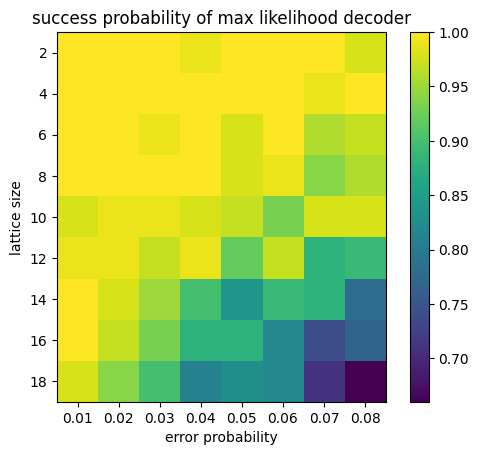

In [25]:
import matplotlib.pyplot as plt

plt.imshow(data_record, cmap='viridis', interpolation='nearest')
plt.xticks(range(len(probability_list)), probability_list)
plt.yticks(range(len(size_list)), size_list)
plt.xlabel('error probability')
plt.ylabel('lattice size')
plt.title('success probability of max likelihood decoder')
plt.colorbar()
plt.show()

# 按照我现在这种decoder，thershold只有大概0.02左右，并不很高，因此需要更好的decoder和更低的物理比特错误